In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/graduate-admissions/Admission_Predict.csv
/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv


In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("mohansacharya/graduate-admissions")
print("Path to dataset files:", path)

# Importing data
student_data = pd.read_csv('/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv') 

# Display the first 10 lines
student_data.head(10)



Path to dataset files: /kaggle/input/graduate-admissions


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


We first define functions to measure time: 

In [3]:
import time

# Define the function to measure how long does it take for a model to run
def tic():
    global start_time
    start_time = time.perf_counter() 

def toc():
    if 'start_time' in globals():
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.4f} seconds.")
    else:
        print("Toc: timer not started. Call tic() first.")

We are interested in the distribution of admission chances, so we first create a histogram: 

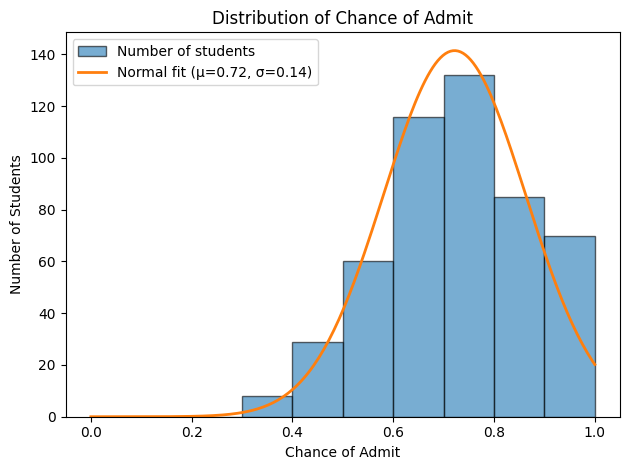

Mean   : 0.722
Median : 0.720


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the chances from the last column
chance = student_data['Chance of Admit '].dropna().values


# Create a histogram to show the distribution of chance of admit 
bin_width = 0.10                                 
bins = np.arange(0, 1 + bin_width, bin_width)    

plt.hist(
    chance,
    bins=bins,
    edgecolor='black',
    alpha=0.60,
    density=False,                              
    label='Number of students'
)

# Then display the normal curve to visualize any trends
mu, sigma = chance.mean(), chance.std()
x = np.linspace(0, 1, 200)                      
pdf = (1 / (sigma * np.sqrt(2 * np.pi))
       * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)))

# Scale the PDF so the area under the curve equals the total sample count
pdf_scaled = pdf * len(chance) * bin_width
plt.plot(x, pdf_scaled,
         linewidth=2,
         label=f'Normal fit (μ={mu:.2f}, σ={sigma:.2f})')


plt.title('Distribution of Chance of Admit')
plt.xlabel('Chance of Admit')
plt.ylabel('Number of Students')
plt.legend()
plt.tight_layout()
plt.show()

# Display the mean and median for chance of admit 
print(f"Mean   : {np.mean(chance):.3f}")
print(f"Median : {np.median(chance):.3f}")


The graph above indicates a roughly normal curve that skewed slightly to the left, hence the empirical threshold of 0.5 is no longer appropriate for this dataset

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The dataset lacks of information for programs or admission-year tags and was compiled in 2018, 
# so we treat it as covering applications from 2013-2018. Fortunately, the acceptance rate is
# appproximate consistently about 25 % in every year. 
# We want to determine an appropriate number for threshold. But for now, we set THRESH = 0.8
# which is apporximately top 25% based on the graph above. We shall update this value later.  
THRESH = 0.8                   
y = (student_data['Chance of Admit '] >= THRESH).astype(int) 


# Create features
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']
X = student_data[features]

# Split the data into training set and validation set
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size = 0.2, random_state=1, stratify=y)

# Scale the data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X   = scaler.transform(val_X)

# Building ANN model with three hidden layers. 
model = keras.Sequential([
    # Input layers
    keras.Input(shape=(7,)),
    # Hidden layers
    layers.Dense(units=4, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1, activation = 'sigmoid'),
])



2025-07-09 14:11:40.238982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752070300.495331      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752070300.567824      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 14:11:58.728590: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Now we compile and fit the model.

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression

# Starting to count time
tic()

# Compile the model 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
     metrics=[
         # Using both accuracy and AUC/ROC as metrics
        keras.metrics.BinaryAccuracy(name='accuracy'),         
        keras.metrics.AUC(name='auc', curve='ROC'),            
    ]
)

# Declare early stopping 
early_stopping = EarlyStopping(
    # If there's no improvement for at least 0.001, then drop the data. 
    min_delta=0.001, 
    # Wait 15 epoches before stopping
    patience=15, 
    restore_best_weights=True,
)

# Fit the model
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=200,
    batch_size=4,
    callbacks = [early_stopping],
    verbose=0
)




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Best validation accuracy = 0.950 at threshold = 0.402


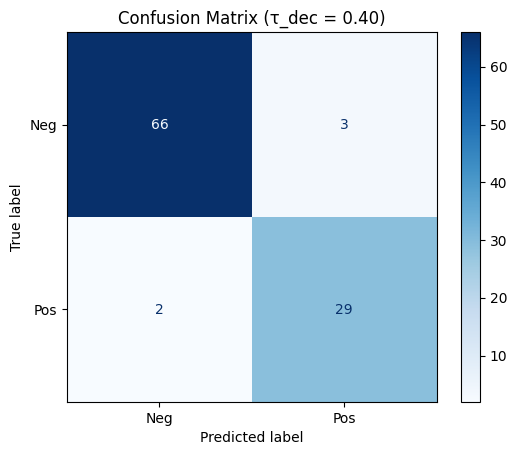

              precision    recall  f1-score   support

           0      0.971     0.957     0.964        69
           1      0.906     0.935     0.921        31

    accuracy                          0.950       100
   macro avg      0.938     0.946     0.942       100
weighted avg      0.951     0.950     0.950       100



In [7]:
from sklearn.metrics import (
    precision_recall_curve,      
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
# Now we shall revisit our original choice for the cut-off value
pred_probs = model.predict(val_X).ravel()

# Compute the precision-recall pairs and store them in thr
prec, rec, thr = precision_recall_curve(val_y, pred_probs)
# Covers every case from everything positive ([0,0]) to everything negative ([1,0])
candidate_thr  = np.concatenate(([0.0], thr, [1.0]))

# Set initial value 
best_acc, best_thr = -1, None

# Loop and update the best case
for t in candidate_thr:
    y_tmp = (pred_probs >= t).astype(int)
    acc   = accuracy_score(val_y, y_tmp)
    if acc > best_acc:
        best_acc, best_thr = acc, t

THRESH_DEC = float(best_thr)
print(f"Best validation accuracy = {best_acc:.3f} at threshold = {THRESH_DEC:.3f}")

# Now we construct a confusion matrix: 
y_pred = (pred_probs >= THRESH_DEC).astype(int)

cm = confusion_matrix(val_y, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Neg', 'Pos']).plot(cmap='Blues')
plt.title(f'Confusion Matrix (τ_dec = {THRESH_DEC:.2f})')
plt.show()

# Display the best THRESH value: 
print(classification_report(val_y, y_pred, digits=3, zero_division=0))




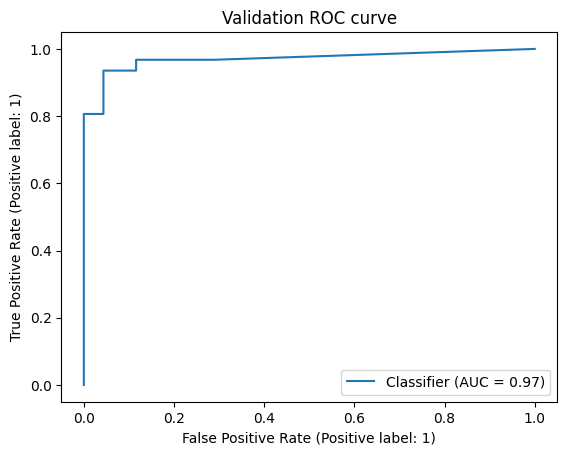

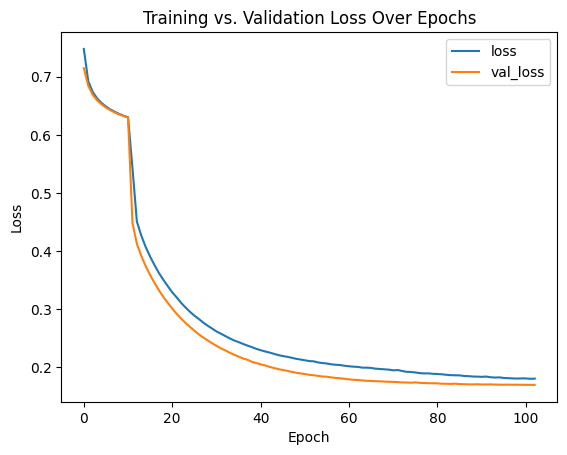

Best Validation Loss: 0.1696


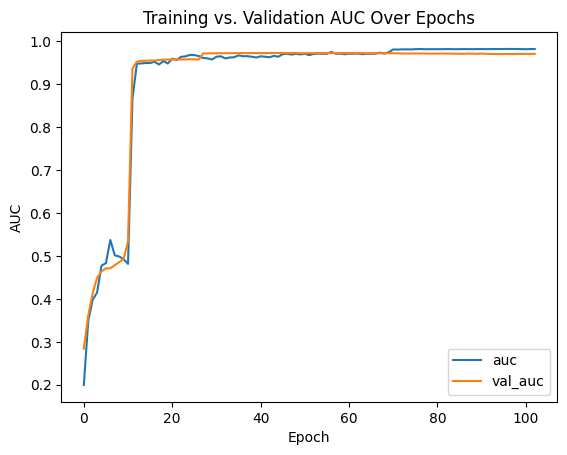

Mean AUC: 0.9126
Best AUC: 0.9724


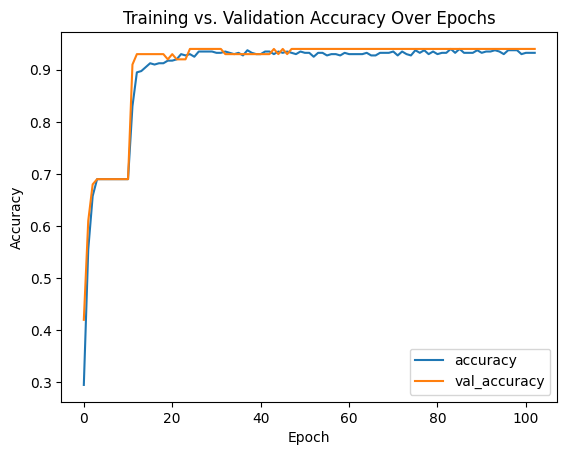

Mean Validation Accuracy: 0.9067
Best Validation Accuracy: 0.9400
Elapsed time: 37.4175 seconds.


In [8]:
# Creating plots for ROC curve: 
RocCurveDisplay.from_predictions(val_y, pred_probs)
plt.title("Validation ROC curve")
plt.show()

# Creating plots for history loss: 
history_df = pd.DataFrame(history.history)
history_df[['loss','val_loss']].plot()
plt.title("Training vs. Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
# We keep 4 decimal places for convenience
print(
    "Best Validation Loss: {:0.4f}"
    .format(history_df['val_loss'].min())
)
 

# Creating graphs for AUC: 
history_df[['auc','val_auc']].plot()
plt.title("Training vs. Validation AUC Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()
print(
    "Mean AUC: {:0.4f}\nBest AUC: {:0.4f}"
    .format(
        history_df['val_auc'].mean(),
        history_df['val_auc'].max()
    )
)

             
      
# Creating graphs for accuracy: 
history_df[['accuracy','val_accuracy']].plot()
plt.title("Training vs. Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
print(
    "Mean Validation Accuracy: {:0.4f}\n"
    "Best Validation Accuracy: {:0.4f}"
    .format(
        history_df['val_accuracy'].mean(),
        history_df['val_accuracy'].max()
    )
)

# End counting time
toc()


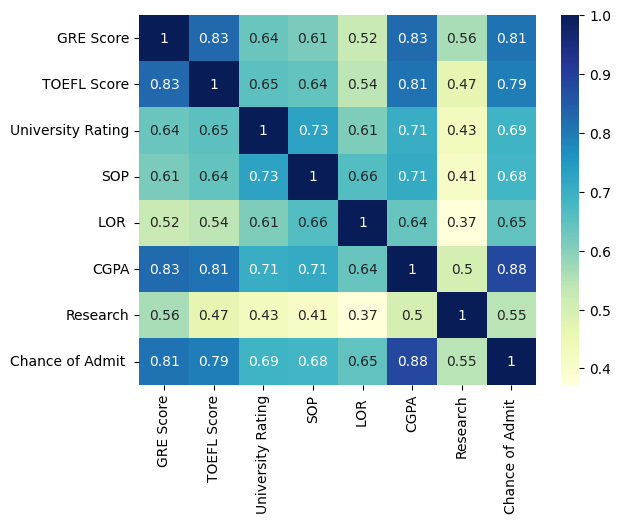

In [9]:
import seaborn as sns

# Create a graph for the correlation between chance of admit to other factors
# Get rid of the first column since it's serial number 
factors = student_data.iloc[:, 1:]
sns.heatmap(factors.corr(),  cmap="YlGnBu", annot=True)
plt.show()


We can see that CGPA has the greatest value of correlation coeffcient, followed by GRE score and TOFEL score. Among all the factors, research has the least affect to chance of admit. 

Now build a logistic regression model: 

Logistic Regression — Validation Accuracy: 0.9400
Logistic Regression — Validation AUC: 0.9762



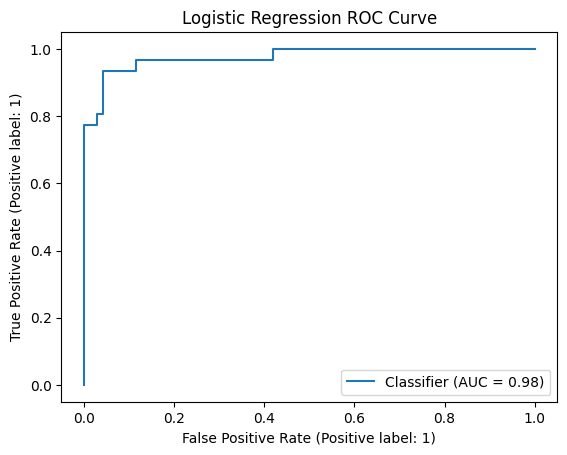

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Define a logistic model
log_model = LogisticRegression(solver='liblinear', random_state=1)

# Fit the logistic regression model
log_model.fit(train_X, train_y)

# Get predictions & probabilities on the validation set
y_pred_log = log_model.predict(val_X)
y_proba_log = log_model.predict_proba(val_X)[:, 1]

# Compute metrics on val set
acc_log = accuracy_score(val_y, y_pred_log)
auc_log = roc_auc_score(val_y, y_proba_log)

# Print the result for accuracy and AUC
print(f"Logistic Regression — Validation Accuracy: {acc_log:.4f}")
print(f"Logistic Regression — Validation AUC: {auc_log:.4f}\n")

# Display the ROC curve grpah
RocCurveDisplay.from_predictions(val_y, y_proba_log)
plt.legend(loc="lower right")
plt.title("Logistic Regression ROC Curve")
plt.show()


Now check for any data leakage: 

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


# First, conduct a row leakage test: 
train_rows = X.iloc[train_y.index]   
val_rows   = X.iloc[val_y.index]

def row_hash(df):
    return pd.util.hash_pandas_object(df, index=False).values

train_hash = row_hash(train_rows)
val_hash   = row_hash(val_rows)

dup_overlap = np.intersect1d(train_hash, val_hash)
print("Exact-row duplicates across splits:", len(dup_overlap))


# Next, doing a quick scan for feature leakage: 
# Confirm no target column in features: 
print("\nTarget column present in feature list?",
      'Chance of Admit ' in features)

# Show top correlations with target
cor = (
    X.assign(target=y)               
    .corr()['target']
    .abs()
    .sort_values(ascending=False)
)

print("\nTop 10 abs(corr) between features and target:")
print(cor.head(10))

Exact-row duplicates across splits: 0

Target column present in feature list? False

Top 10 abs(corr) between features and target:
target               1.000000
CGPA                 0.742278
TOEFL Score          0.699101
GRE Score            0.683633
University Rating    0.618279
SOP                  0.581077
LOR                  0.500391
Research             0.498311
Name: target, dtype: float64


We can see that there are no duplicate rows and no target columns in the feature list. In addition, the highest correlation value between the feature and target is CGPA, with a number of 0.74. This indicates a relatively strong correlation but not suspiciously perfect. Hence, there is no data leakage. 